## Tratamento dos dados

#### Importação das bibliotecas

In [2]:
import pandas as pd
import os
from graph_tool import Graph, stats, spectral
from netpixi.data.gt import *
import netpixi
import cpnet
import seaborn as sns
from math import sqrt
from matplotlib import rcParams
import statsmodels.formula.api as smf
import numpy as np
from scipy.stats import norm

#### Ligas disponíveis

O dataset de transferências possui os dados das seguintes ligas:

#### Problemas:

- Sub21 e Sub18
DATA_DIR = './data/transfers_master/data'- Incoerência entre as colunas club_name e club_involved_name

In [3]:
DATA_DIR = './data/transfers_master/data'
os.listdir(DATA_DIR + '/' + '2014')

['italian_serie_a.csv',
 'english_premier_league.csv',
 'german_bundesliga_1.csv',
 'english_championship.csv',
 'portugese_liga_nos.csv',
 'russian_premier_liga.csv',
 'spanish_primera_division.csv',
 'french_ligue_1.csv',
 'dutch_eredivisie.csv']

#### Loading Data

Função para carregar o dataset. Recebe o diretório que o data está salvo e o ano.

In [4]:
def loading_data(DATA_DIR, year):
    
    # Leitura do primeiro dataset para carregar as columns
    dir = "./data/transfers_master/data/"+ year + "/dutch_eredivisie.csv"
    data = pd.read_csv(dir)

    # Loop desconsidera o primeiro elemento (carregado no código acima)
    for league in os.listdir(DATA_DIR + '/' + year)[1:]:
            string = (DATA_DIR + '/' + year + '/' + league)
            data_temp = pd.read_csv(string)
            
            # Concatenação dos dados
            data = pd.concat([data, data_temp])
     
    return(data)

def concat_year(start, end, DATA_DIR, data):
    
    for year in range(start, end+1):
        data = pd.concat([data, loading_data(DATA_DIR, str(year))])
        
    return data

In [5]:
DATA_DIR = './data/transfers_master/data'
YEAR = '1992'

data = loading_data(DATA_DIR, YEAR)
# data

In [6]:
data = concat_year(1993, 2015, DATA_DIR, data)

In [7]:
data_in = data.loc[data["transfer_movement"] == "in"]
data_out = data.loc[data["transfer_movement"] == "out"]
data_in = data_in.reset_index()
data_out = data_out.reset_index()

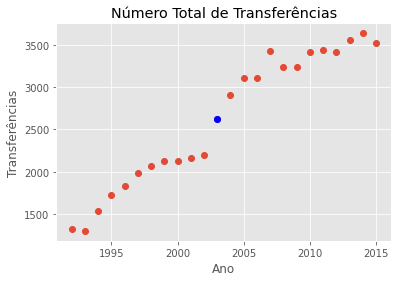

In [8]:
import matplotlib.pyplot as plt

pl = data_in["year"].value_counts()
pre_gal = pl.sort_index()
pos_gal = pl.sort_index()
pre_gal = pre_gal[:11]
pos_gal = pos_gal[11:]

plt.style.use('ggplot')
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.plot(pl.sort_index(), 'o', label = "Transferências")
plt.plot(2003 ,pl[2003], 'bo', label = "Era");

## Pré-Galácticos e Pós-Galacticos

O gráfico acima mostra a evolução no número de transferências de jogadores ao longo dos anos, dessa forma pode-se perceber que 2003 foi o ano em que houve a maior evolução no número de movimentações no mercado do futebol europeu da história. Portanto, deixou-se essa data como destaque em azul no gráfico, marcando o fim da era dos galácticos e o começo da era pós galácticos.

Assim, como o segundo gráfico mostra os anos em rosa que indicam a era pré-galácticos e os em azul a era pós-galácticos. 

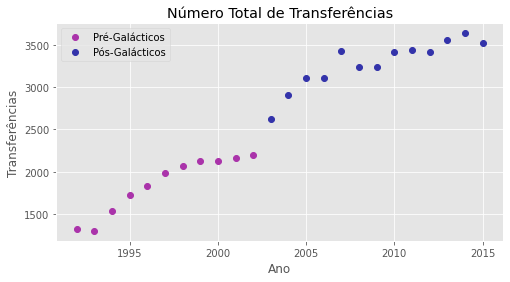

In [9]:
plt.figure(figsize = (8,4))
plt.plot(pre_gal, 'o', label = "Pré-Galácticos", color = "#AA33AA")
plt.plot(pos_gal, 'o', label = "Pós-Galácticos", color = "#3333AA")
plt.title("Número Total de Transferências")
plt.xlabel("Ano")
plt.ylabel("Transferências")
plt.legend(loc="upper left")
plt.show()

In [10]:
in_names = list(data_in["club_name"].value_counts().index)
out_names = list(data_in["club_involved_name"].value_counts().index)
name_dic = {}
problems = ["Olympique Marseille", "Olympique Lyon", "Eintracht Braunschweig", "Eintracht Frankfurt"]
for in_str in in_names:
    for out_str in out_names:

        if out_str[:10] in in_str and out_str != in_str:
            if (out_str not in problems) or (in_str not in problems):
#                 print(in_str ,", ", out_str)
                name_dic[out_str] = in_str

In [11]:
for k,v in name_dic.items():
    data_in["club_involved_name"].replace({k: v}, inplace=True)
    
# data_in

In [12]:
data_pre_gal = data_in[data_in["year"] <= 2003]
data_pos_gal =  data_in[data_in["year"] > 2003]

In [13]:
rede_normal = Graph(directed=True) # dirigido
rede_normal.vp['name'] = rede_normal.new_vp('object')
rede_normal.vp['league'] = rede_normal.new_vp('object')
rede_normal.ep["transfer"] = rede_normal.new_ep('object')

In [14]:
times = []
for index, rows in data_pos_gal.iterrows():
    time1 = rows[1]
    time2 = rows[5]
    if time1 not in times:
        times.append(time1)
        rede_normal.add_vertex()
        v_time = rede_normal.vertex(times.index(time1))
        rede_normal.vp['name'][v_time] = time1
        rede_normal.vp['league'][v_time] = rows[10]
        
    if time2 not in times:
        times.append(time2)
        rede_normal.add_vertex()
        v_time = rede_normal.vertex(times.index(time2))
        rede_normal.vp['name'][v_time] = time2
        rede_normal.vp['league'][v_time] = rows[10]
    
    index1 = times.index(time1)
    index2 = times.index(time2)
    
    if rede_normal.edge(index1, index2) == None:
        rede_normal.add_edge(index1, index2)
        e = rede_normal.edge(index1, index2)
        rede_normal.ep["transfer"][e] = 1
    else:
        e = rede_normal.edge(index1, index2)
        rede_normal.ep["transfer"][e] = rede_normal.ep["transfer"][e] + 1

In [15]:
data_in["league_name"].value_counts()

Championship        12342
Eredivisie          11216
Premier League       9652
Liga Nos             7382
Ligue 1              6365
Primera Division     5988
1 Bundesliga         5163
Premier Liga         4923
Name: league_name, dtype: int64

In [16]:
rede_normal.vp['color'] = rede_normal.new_vp('object')

for v in rede_normal.vertices():
    if rede_normal.vp['league'][v] == "Premier League":
        rede_normal.vp['color'][v] = 0x0000ff
        
    if rede_normal.vp['league'][v] == "Eredivisie":
        rede_normal.vp['color'][v] = 0x00ff00
        
    if rede_normal.vp['league'][v] == "Championship":
        rede_normal.vp['color'][v] = 0x0000f0
        
    if rede_normal.vp['league'][v] == "Serie A":
        rede_normal.vp['color'][v] = 0xff00ff
        
    if rede_normal.vp['league'][v] == "Liga Nos":
        rede_normal.vp['color'][v] = 0xff0000
        
    if rede_normal.vp['league'][v] == "Ligue 1":
        rede_normal.vp['color'][v] = 0xffff00
        
    if rede_normal.vp['league'][v] == "1 Bundesliga":
        rede_normal.vp['color'][v] = 0x1100ff
        
    if rede_normal.vp['league'][v] == "Premier Liga":
        rede_normal.vp['color'][v] = 0x00ffff
        
stats.remove_self_loops(rede_normal)
m = draw_gt.sfdp_layout(rede_normal)
move_gt(rede_normal, m)
save_gt(rede_normal, 'rede_normal.net.gz')
# r = netpixi.render('exemplo4.net.gz')

In [17]:
def centro_periferia(g, t):
    matrix = spectral.adjacency(g)
    if t == "core":
        algorithm = cpnet.LowRankCore()
    elif t == "coreness":
        algorithm = cpnet.MINRES()

    algorithm.detect(matrix)
    c = algorithm.get_coreness()

    g.vp[t] = g.new_vp('object')
    for i, coreness in c.items():
        v = g.vertex(i)
        g.vp[t][v] = float(coreness)

In [18]:
centro_periferia(rede_normal, "core")

In [19]:
df = pd.DataFrame({k: list(v) for k, v in rede_normal.vp.items()})
df.head()

,name,league,color,_x,_y,core
0,Ajax Amsterdam,Eredivisie,65280.0,-0.715061,4.643465,1.0
1,Newell's,Eredivisie,65280.0,-0.689000,4.619676,0.0
2,SC Heerenveen,Eredivisie,65280.0,-0.717400,4.661721,0.0
3,Boca Juniors,Eredivisie,65280.0,-0.715808,4.616207,0.0
4,Figueirense FC,Eredivisie,65280.0,-0.735528,4.602365,0.0


In [20]:
df["league"].value_counts()

Liga Nos            552
Championship        368
Premier Liga        360
Eredivisie          324
Premier League      312
1 Bundesliga        256
Ligue 1             235
Primera Division    186
Name: league, dtype: int64

In [21]:
def plot_cp(df):
    plt.figure(figsize=(16,8))
    plt.plot(df[df["league"] == "Eredivisie"]["_x"], df[df["league"] == "Eredivisie"]["_y"],
             'o', markersize=12, label = "Eredivisie", alpha=.5)
    plt.plot(df[df["league"] == "Liga Nos"]["_x"], df[df["league"] == "Liga Nos"]["_y"],
             'o', markersize=12, label = "Liga Nos", alpha=.5)
    plt.plot(df[df["league"] == "Premier Liga"]["_x"], df[df["league"] == "Premier Liga"]["_y"],
             'o', markersize=12, label = "Premier Liga", alpha=.5)
    plt.plot(df[df["league"] == "Championship"]["_x"], df[df["league"] == "Championship"]["_y"],
             'o', markersize=12, label = "Championship", alpha=.5)
    plt.plot(df[df["league"] == "Serie A"]["_x"], df[df["league"] == "Serie A"]["_y"],
             'o', markersize=12, label = "Serie A", alpha=.5)
    plt.plot(df[df["league"] == "Ligue 1"]["_x"], df[df["league"] == "Ligue 1"]["_y"],
             'o', markersize=12, label = "Ligue 1", alpha=.5)
    plt.plot(df[df["league"] == "Premier League"]["_x"], df[df["league"] == "Premier League"]["_y"],
             'o', markersize=12, label = "Premier League", alpha=.5)
    plt.plot(df[df["league"] == "1 Bundesliga"]["_x"], df[df["league"] == "1 Bundesliga"]["_y"],
             'o', markersize=12, label = "1 Bundesliga", alpha=.5)
    plt.title("Classificação core & liga")
    plt.xlabel("posição em X")
    plt.ylabel("posição em Y")
    plt.legend(loc = "upper right")
    plt.show()

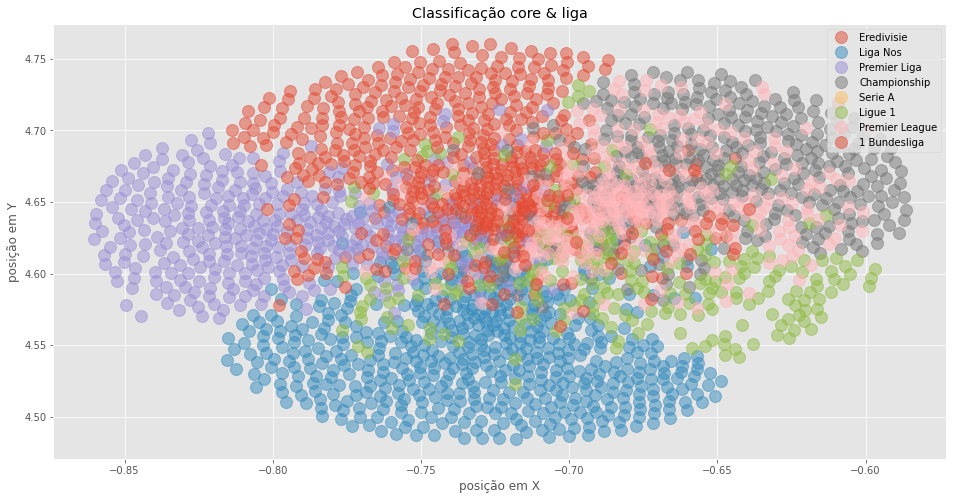

In [22]:
plot_cp(df)

## Conclusão sobre o grafo das tranferências entre clubes europeus

Observando o grafo plotado, é possível observar panelinhas entre as ligas do futebol europeu, fica bem claro a concentração entre os times de mesma liga quando se olha para as cores e os devidos posicionamentos dos vértices ao longo da rede, assim fica mais evidente a possível existência de times que interligam tranferências entre as ligas, os quais corroboram para a hipótese do grupo.

**Hipótese: Times com boa relação com times de diferentes ligas (relacionamento interliga) atingem melhor desempenho na champions league**


In [23]:
def loading_champions_data(DATA_DIR, year, end):
    list_df = []
    str_year = f"{year}-{str(year+1)[-2:]}"
    dir = "./data/champions_league/"+ str_year + "/champs.csv"
    data = pd.read_csv(dir)
    list_df.append(data)
    start = year + 1
    
    for year in range(start, end+1):
        str_year = f"{year}-{str(year+1)[-2:]}"
        dir = "./data/champions_league/"+ str_year + "/champs.csv"
        
        #data = pd.concat([data, pd.read_csv(dir)])
        data = pd.read_csv(dir)
        list_df.append(data)
    return(list_df)

In [24]:
DATA_DIR = './data/champions_league'
YEAR = 1993

list_df = loading_champions_data(DATA_DIR, YEAR, 2015)
list_df[1]


,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments
0,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),AEK Athens › GRE (1),2-0,0-0,Rangers FC › SCO (1),NaN,NaN,NaN,NaN
1,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Avenir Beggen › LUX (1),1-5,0-0,Galatasaray İstanbul AŞ › TUR (1),NaN,NaN,NaN,NaN
2,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Silkeborg IF › DEN (1),0-0,0-0,Dinamo Kiev › UKR (1),NaN,NaN,NaN,NaN
3,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Paris Saint-Germain › FRA (1),3-0,0-0,Dunakanyar-Vac › HUN (1),NaN,NaN,NaN,NaN
4,Qualifying,Prelim. Round | Leg 1,NaN,(Wed) 10 Aug 1994 (W32),Legia Warsaw › POL (1),0-1,0-0,Hajduk Split › CRO (1),NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
72,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Paris Saint-Germain › FRA (11),0-1,0-0,AC Milan › ITA (9),NaN,NaN,NaN,NaN
73,Knockout,Semifinals | Leg 1,NaN,(Wed) 5 Apr 1995 (W14),Bayern München › GER (9),0-0,0-0,AFC Ajax › NED (9),NaN,NaN,NaN,NaN
74,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AFC Ajax › NED (10),5-2,3-1,Bayern München › GER (10),5-2 (agg.),NaN,NaN,NaN
75,Knockout,Semifinals | Leg 2,NaN,(Wed) 19 Apr 1995 (W16),AC Milan › ITA (10),2-0,1-0,Paris Saint-Germain › FRA (12),3-0 (agg.),NaN,NaN,NaN


In [26]:
def calcula_pontos(stage,round_,time1,time2,time1_placar,time2_placar,comentarios,dict_teams):
    pontos_ = 0
    if stage == 'Qualifying':
        pontos_=1
    elif stage == 'Group':
        pontos_=3
    else:
        pontos_ = 5
    if round_ == 'Final':
        pontos_ = 10
    
    
    if time1 not in dict_teams:
        dict_teams[time1] = 0
        
    if time2 not in dict_teams:
        dict_teams[time2] = 0
        
    if comentarios !=0:
        if comentarios == 1:
            time_vencedor = time1
        if comentarios == 2:
            time_vencedor = time2
    
    if time1_placar > time2_placar:
        time_vencedor = time1
    else:
        time_vencedor = time2
    dict_teams[time_vencedor] +=pontos_


In [30]:
dict_teams = {}
for i in range(len(list_df)):
    list_df[i]['Team 1'] = list_df[i]['Team 1'].str.split(' ›').str[0]
    list_df[i]['Team 2'] = list_df[i]['Team 2'].str.split(' ›').str[0]
    #list_df[i] = list_df[i].dropna(subset=['∑FT'])
    # limpando '∑FT'
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("(","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(")","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("a ","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace("agg.","")
    list_df[i]['∑FT'] = list_df[i]['∑FT'].str.replace(" ","")
    list_df[i]['time1_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[0]
    list_df[i]['time2_placar_agregado'] = list_df[i]['∑FT'].str.split('-').str[1]
    # limpando P
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace('(','')
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace(")","", regex=True)
    list_df[i]['P'] = list_df[i]['P'].astype(str).str.replace("pen.","", regex=True)
    list_df[i]['time1_penalti'] = list_df[i]['P'].str.split('-').str[0]
    list_df[i]['time2_penalti'] = list_df[i]['P'].str.split('-').str[1]
    
    # limpando Comments (Away Goals)
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('(','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace(')','')
    list_df[i]['Comments'] = list_df[i]['Comments'].str.replace('Away Goals ','')
    
    list_df[i]['time1_placar'] = list_df[i]['FT'].str.split('-').str[0]
    list_df[i]['time1_placar'] = list_df[i]['time1_placar'].str.replace(' ','')
    list_df[i]['time2_placar'] = list_df[i]['FT'].str.split('-').str[1]
    list_df[i] = list_df[i].drop(list_df[i][((list_df[i]['Stage'] == 'Knockout') & (list_df[i]['∑FT'].isnull()) & (list_df[i]['Round'] != 'Final'))].index)

    
    for index, rows in list_df[i].iterrows():
        stage = rows[0]
        round_ = rows[1]
        time1 = rows[4]
        time2 = rows[7]
        comments = rows[11]
        time1_placar_agregado = rows[12]
        time2_placar_agregado = rows[13]
        time1_penalti = rows[14]
        time2_penalti = rows[15]
        time1_placar = rows[16]
        time2_placar = rows[17]
        # checar se houve penalti
        if time1_penalti != 'nan':
            calcula_pontos(stage, round_,time1,time2,int(time1_penalti),int(time2_penalti),0, dict_teams)  
        # checar se teve gol fora de casa 
        elif comments == '1' or comments =='2':
            calcula_pontos(stage, round_,time1,time2,0,0,int(comments),dict_teams)
        # ver se é um jogo com placar agregado
        elif  type(time1_placar_agregado) == str:
            pass
            calcula_pontos(stage, round_,time1,time2,int(time1_placar_agregado),int(time2_placar_agregado),0,dict_teams)
        # passar o placar comum
        else:
            #print(time1_placar[0])
            calcula_pontos(stage, round_,time1,time2,int(time1_placar[0]),int(time2_placar[0]),0,dict_teams)

In [31]:
{k: v for k, v in sorted(dict_teams.items(), key=lambda item: item[1])}


{'Avenir Beggen': 0,
 'B68 Toftir': 0,
 'FK Partizani Tirana': 0,
 'Kispesti Honved': 0,
 'Silkeborg IF': 0,
 'Dunakanyar-Vac': 0,
 'Servette Geneve': 0,
 'Alania Vladikavkaz': 0,
 'FK Kareda Kaunas': 0,
 'Derry City': 0,
 'Lantana Tallinn': 0,
 'FC Tiraspol': 0,
 'GI Gota': 0,
 'Jeunesse Esch': 0,
 'Cliftonville': 0,
 'FK Vllaznia': 0,
 'FC Yerevan': 0,
 'Flora Tallinn': 0,
 'Kapaz': 0,
 'FC Metz': 0,
 'Araks Ararat': 0,
 'Glentoran': 0,
 'Dnepr Mogilev': 0,
 'Rapid Bucuresti': 0,
 'HNK Rijeka': 0,
 'Teplice': 0,
 'KI Klaksvik': 0,
 'NK Brotnjo': 0,
 'Shamkir': 0,
 'SSW Innsbruck': 0,
 'St. Gallen': 0,
 'HB Koge': 0,
 'TSV 1860 Munchen': 0,
 'Vagur': 0,
 'Lugano': 0,
 'Portadown': 0,
 'NK Zagreb': 0,
 'Hammarby': 0,
 'Lillestrom': 0,
 'Grevenmacher': 0,
 'FK Pobeda': 0,
 'Gomel': 0,
 'Rhyl': 0,
 'PFC Lokomotiv Plovdiv': 0,
 'Banik Ostrava': 0,
 'Everton FC': 0,
 'TVMK': 0,
 'Apollon Limassol': 0,
 'Shakhtyor Soligorsk': 0,
 'AC Chievo Verona': 0,
 'Metalurgi Rustavi': 0,
 'Murata': 0,

In [29]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(list_df[-1])

,Stage,Round,Group,Date,Team 1,FT,HT,Team 2,∑FT,ET,P,Comments,time1_placar_agregado,time2_placar_agregado,time1_penalti,time2_penalti,time1_placar,time2_placar
0,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 30 Jun 2015 (W26),Crusaders,0-0,0-0,Levadia,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,0,0
1,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 30 Jun 2015 (W26),Lincoln Red Imps,0-0,0-0,FC Santa Coloma,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,0,0
2,Qualifying,Qual. Round 1 | Leg 1,NaN,(Tue) 30 Jun 2015 (W26),Pyunik,2-1,0-0,S.S. Folgore Falciano Calcio,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,2,1
3,Qualifying,Qual. Round 1 | Leg 1,NaN,(Wed) 1 Jul 2015 (W26),B36 Torshavn,1-2,0-0,The New Saints,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,1,2
4,Qualifying,Qual. Round 1 | Leg 2,NaN,(Tue) 7 Jul 2015 (W27),Levadia,1-1,0-0,Crusaders,1-1,NaN,nan,2,1,1,nan,NaN,1,1
5,Qualifying,Qual. Round 1 | Leg 2,NaN,(Tue) 7 Jul 2015 (W27),The New Saints,4-1,0-0,B36 Torshavn,6-2,NaN,nan,NaN,6,2,nan,NaN,4,1
6,Qualifying,Qual. Round 1 | Leg 2,NaN,(Tue) 7 Jul 2015 (W27),FC Santa Coloma,1-2,0-0,Lincoln Red Imps,1-2,NaN,nan,NaN,1,2,nan,NaN,1,2
7,Qualifying,Qual. Round 1 | Leg 2,NaN,(Tue) 7 Jul 2015 (W27),S.S. Folgore Falciano Calcio,1-2,0-0,Pyunik,2-4,NaN,nan,NaN,2,4,nan,NaN,1,2
8,Qualifying,Qual. Round 2 | Leg 1,NaN,(Tue) 14 Jul 2015 (W28),AS Trencin,0-2,0-0,Steaua Bucuresti,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,0,2
9,Qualifying,Qual. Round 2 | Leg 1,NaN,(Tue) 14 Jul 2015 (W28),APOEL Nikosia,0-0,0-0,Vardar Skopje,NaN,NaN,nan,NaN,NaN,NaN,nan,NaN,0,0
